 **High-Frequency (Cypto price) trading rules using Machine Learning**
 
 Version 2.0
 
 Momentum strategy + Meta-Labeling


1. Financial Data and Bars 
 - OHLCV Bar
 - Summary and plot


2. Getting Trend Signals (Long only)
 - RSI with different windows


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with signals
 - Binary Labeling (Profit or Loss)


4. Secondary Model

 4.1. Features (X)
 - Market/ Microstructure features/ Fundamentals/ Sentiments/ 
 - Feature Scaling (MinMaxScaler)
 - Feature Engineering (PCA/ Autoencoder)
 
 4.2. Prediction Model
 - Cross-Validation/ Simple Split
 - AutoML with *autogluon* and select the best model
 - Results
 
 4.2. Trading
 - Bet Sizing
 
 
5. Results
 - Cumulative returns, Sharpe Ratio, Drawdown


In [344]:
# De Prado AMFL
import triple_barrier as tb

# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.stats import norm, moment

#feature
from sklearn import preprocessing
from sklearn.decomposition import PCA 

# CV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

#ML
import autogluon as ag


# Technical analysis
import ta
import getTA #local
import tautil #local

# Backtesting pyfolio
import pyfolio as pf

In [345]:
import warnings
warnings.filterwarnings(action='ignore')

In [346]:
def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# 1. Financial Data and Bars

## OHLCV Bar

- ETH/USD 
- 5 minutes OHLCV(open, high, low, close, volume)

In [347]:
df_raw = pd.read_csv('ethusd5min.csv')
df = df_raw.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [348]:
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705,1546301099999,1.666154e+05,404,583.71526,7.665267e+04,0
2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843,1546301399999,2.102706e+05,329,970.39345,1.273754e+05,0
2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337,1546301699999,7.359844e+04,255,237.78679,3.121957e+04,0
2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505,1546301999999,8.559326e+04,203,173.81466,2.282429e+04,0
2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218,1546302299999,6.572714e+04,275,232.22948,3.049598e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13 23:40:00,1941.97,1943.71,1940.34,1943.25,392.24754,1626219899999,7.618761e+05,925,265.19319,5.150956e+05,0
2021-07-13 23:45:00,1943.24,1943.24,1932.66,1933.79,1233.82503,1626220199999,2.389417e+06,2173,612.61804,1.186551e+06,0
2021-07-13 23:50:00,1933.79,1935.73,1931.38,1933.40,1011.00253,1626220499999,1.954553e+06,1957,498.29748,9.634496e+05,0


In [349]:
# for faster calculating let's use shorter period.
#df = df.loc['2021-2':,:]

In [350]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [351]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume,buy_volume]).T
df_ohlcv.describe()

,open,high,low,close,volume,tb_base_av
count,265681.000000,265681.000000,265681.000000,265681.000000,265681.000000,265681.000000
mean,626.847616,628.366692,625.289446,626.853784,2593.840088,1294.716549
std,813.984362,816.369880,811.548609,813.987228,3490.654040,1750.312681
min,88.440000,93.590000,86.000000,88.350000,0.000000,0.000000
25%,170.570000,170.840000,170.290000,170.580000,766.388620,371.348880
50%,234.880000,235.120000,234.610000,234.880000,1551.444150,764.346200
75%,538.260000,539.500000,536.970000,538.270000,3028.700230,1515.107460
max,4360.460000,4372.720000,4350.010000,4360.460000,105591.963390,54594.127000


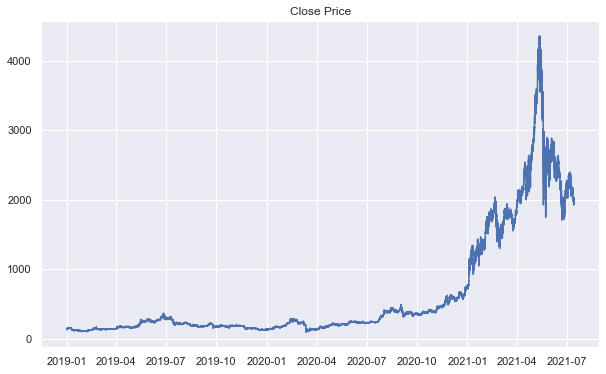

In [352]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('image/close_price.jpg')
plt.show();

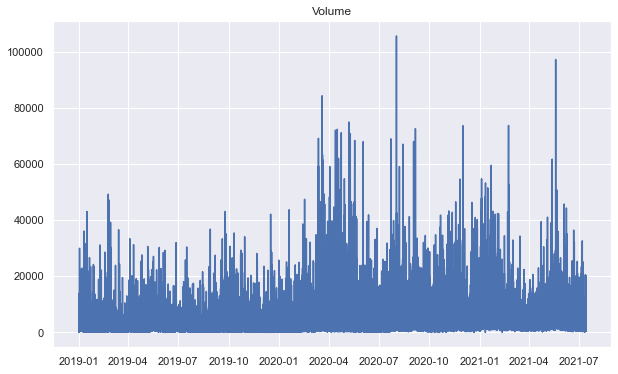

In [353]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('image/volume.jpg')
plt.show();

In [354]:
of = buy_volume - (volume-buy_volume)

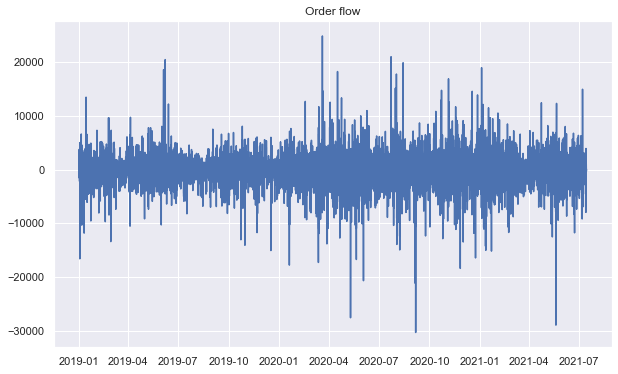

In [355]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('image/order_flow.jpg')
plt.show();

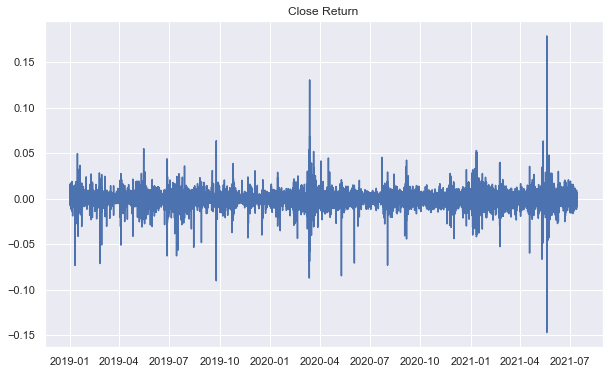

In [356]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('image/closereturn.jpg')
plt.show();

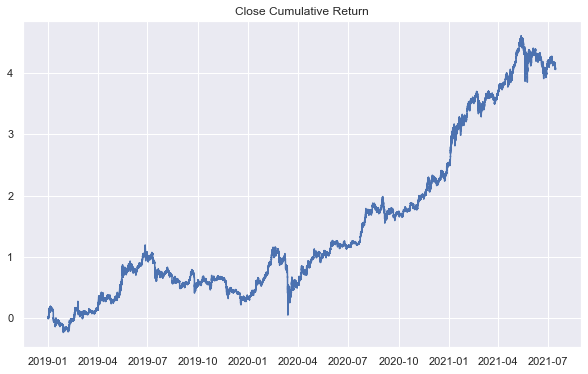

In [357]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.savefig('image/closecumreturn.jpg')
plt.show();

# 2. Getting Trend Signals

 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

In [358]:
windows = np.arange(5,50,5)

For example, let's see the RSI(relative strength index), which is the momentum indicator

I made the threshold to choose when to long or short. 

In [359]:
rsi_df = pd.DataFrame(index=df.index)

In [360]:
for w in windows:
    rsi_df['rsi_{}'.format(w)] = tautil.my_rsi_2(close, w)
rsi_df.dropna(inplace=True)

In [361]:
rsi_df

,rsi_5,rsi_10,rsi_15,rsi_20,rsi_25,rsi_30,rsi_35,rsi_40,rsi_45
timestamp,,,,,,,,,
2019-01-01 04:20:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 04:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 05:10:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 05:15:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 05:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2021-07-13 22:40:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-07-13 22:45:00,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-07-13 22:50:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


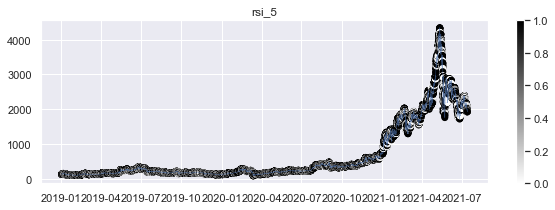

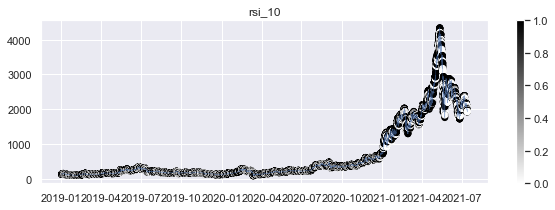

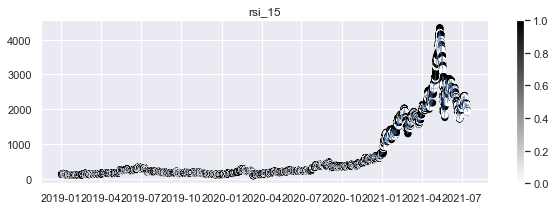

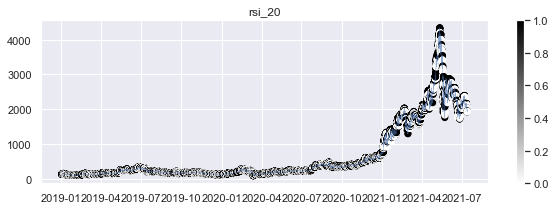

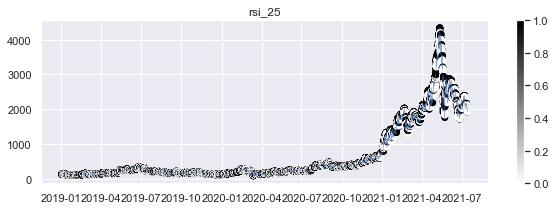

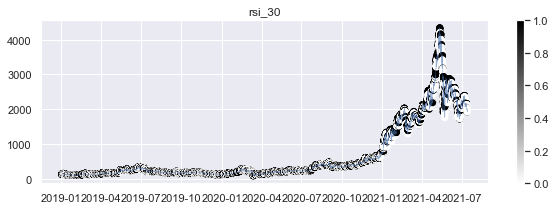

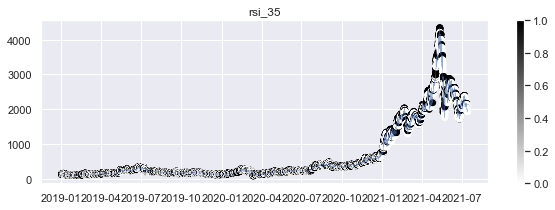

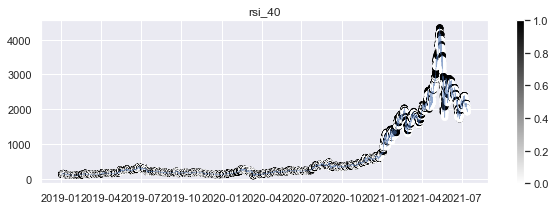

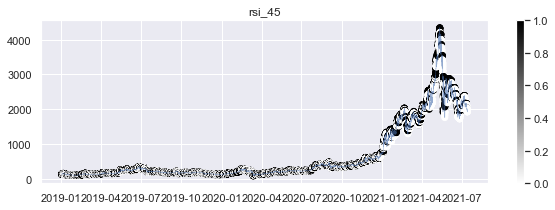

In [362]:
# long signals

for i in rsi_df.columns:
    sc = rsi_df[i].copy()
    plt.figure(figsize=(10,3))
    plt.plot(close.loc[sc.index], linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', alpha=1, vmin=0,vmax=1)
    plt.colorbar()
    plt.title('{}'.format(i))
    plt.show()

## 3. Labeling with Triple-Barrier Method
 ### Form Symmetric Triple Barrier with signals
 

Below is for testing various windows.

In [363]:
#returns_df = pd.DataFrame()

#for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.05,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
#    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [364]:
#for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [365]:
#returns_df.cumsum()

For simplicity, I will choose rsi window = 10 for this asset and interval.

You can use other methods, for example combining with MACD.


In [366]:
rsi_w = 'rsi_25'
long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
enter = long.index
pt_sl = [0.05,0.05] # profit-taking, stop-loss target
max_holding = [14,0] #[day,hours]
barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)

Make triple barrier using long signals, profit-taking/stop-loss target returns (must be symmetric), and maximum holding period.

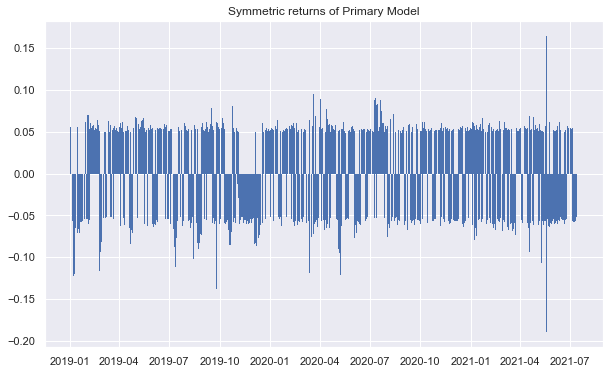

In [367]:
ret = barrier.ret
plt.figure(figsize=(10,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.savefig('image/returns_of_1stmodel.jpg')
plt.show();

You can see the symmetric returns, except for those who exceed max holding periods. 

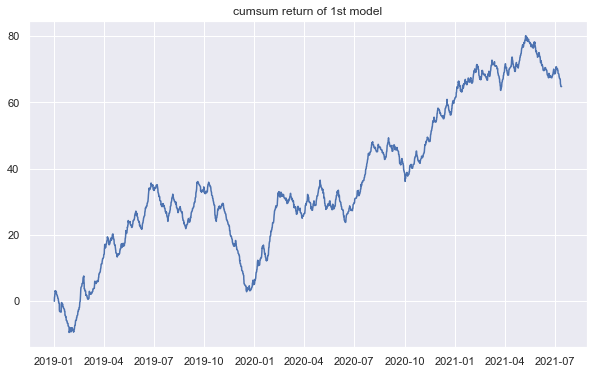

In [368]:
plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

### Binary Labeling (Profit or Loss)

In [369]:
first_model = pd.DataFrame()
first_model['y_pred'] = long
first_model['y_true'] = np.sign(long*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

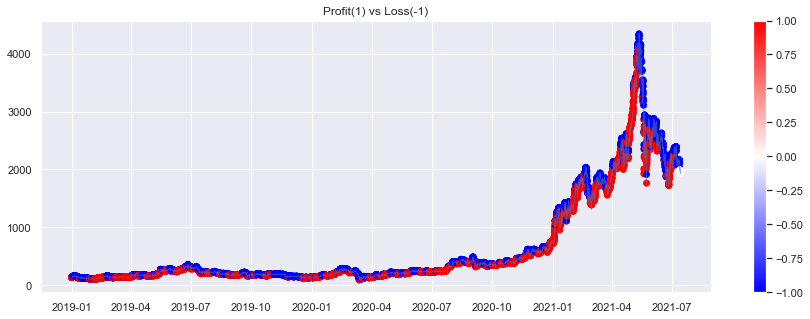

In [370]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [371]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

 1.0    7546
-1.0    5716
Name: y_true, dtype: int64

In [372]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.5689941185341577


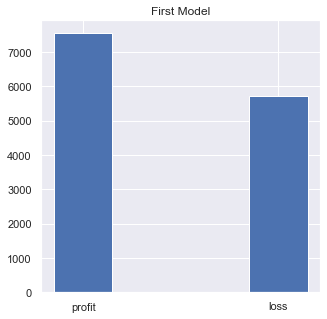

In [373]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

## 4. Secondary Model

 ### 4.1. Features (X)
 ####  Market data

Market
- Techincal indicators with market data

In [374]:
ohlcv = df.iloc[:,:5]
df_ = ohlcv

In [375]:
TA_ = getTA.get_ta(df_).dropna()
TA = TA_.drop(columns=['open','high','low'])

In [376]:
mkt = TA.copy()

for i in [1,5,12]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [10,40,80]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))
                   

corr = mkt.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,close,volume,m_rsi,m_roc,m_cmo,m_wr,vm_cmf,vm_mfi,vm_fi,vm_eom,vl_bbp,vl_atr,t_macdd,t_trix,t_cci,t_dpo,t_kst,t_adx,vol_mom_1,of_mom_1,mom_1,vol_mom_5,of_mom_5,mom_5,vol_mom_12,of_mom_12,mom_12,std_10,vol_std_10,std_40,vol_std_40,std_80,vol_std_80
close,1.00,0.21,0.02,0.01,0.02,0.03,0.01,0.02,-0.03,-0.00,0.01,0.80,0.00,0.01,0.01,-0.00,0.01,0.02,-0.00,0.00,0.00,-0.00,0.00,0.01,-0.00,0.00,0.01,0.70,0.11,0.75,0.12,0.77,0.13
volume,0.21,1.00,-0.02,-0.09,-0.02,-0.00,0.03,-0.01,-0.18,-0.04,-0.03,0.38,-0.06,-0.08,-0.03,0.04,-0.07,0.24,0.36,-0.02,-0.03,0.49,-0.05,-0.07,0.53,-0.06,-0.10,0.44,0.70,0.37,0.58,0.34,0.52
m_rsi,0.02,-0.02,1.00,0.71,0.86,0.75,0.53,0.76,0.21,0.12,0.89,-0.02,0.31,0.54,0.87,-0.17,0.56,-0.04,-0.01,0.02,0.17,-0.02,0.08,0.34,-0.03,0.12,0.41,-0.02,-0.04,0.01,-0.02,0.01,0.00
m_roc,0.01,-0.09,0.71,1.00,0.74,0.61,0.42,0.61,0.42,0.15,0.66,-0.03,0.57,0.43,0.64,-0.42,0.47,-0.04,-0.02,0.01,0.19,-0.05,0.03,0.43,-0.12,0.20,0.68,-0.06,-0.11,-0.01,-0.03,0.00,-0.01
m_cmo,0.02,-0.02,0.86,0.74,1.00,0.79,0.49,0.80,0.18,0.09,0.86,-0.01,0.37,0.34,0.84,-0.23,0.37,-0.02,-0.01,0.01,0.13,-0.02,0.04,0.28,-0.03,0.08,0.44,-0.01,-0.04,0.01,0.00,0.01,0.01
m_wr,0.03,-0.00,0.75,0.61,0.79,1.00,0.47,0.58,0.15,0.15,0.88,0.02,0.37,0.13,0.84,-0.20,0.16,0.01,-0.01,0.04,0.21,-0.03,0.10,0.35,-0.04,0.16,0.38,0.01,0.00,0.03,0.04,0.02,0.04
vm_cmf,0.01,0.03,0.53,0.42,0.49,0.47,1.00,0.45,0.14,0.06,0.49,-0.02,0.23,0.31,0.49,-0.09,0.34,0.03,-0.01,0.01,0.09,-0.01,0.03,0.19,-0.02,0.05,0.28,-0.02,0.04,0.01,0.06,-0.01,0.06
vm_mfi,0.02,-0.01,0.76,0.61,0.80,0.58,0.45,1.00,0.15,0.05,0.72,-0.01,0.30,0.39,0.72,-0.15,0.41,-0.04,-0.00,-0.01,0.07,-0.01,0.01,0.22,-0.02,0.03,0.36,-0.01,-0.04,0.01,-0.00,0.01,0.01
vm_fi,-0.03,-0.18,0.21,0.42,0.18,0.15,0.14,0.15,1.00,0.34,0.18,-0.15,0.54,0.21,0.18,-0.28,0.23,-0.04,-0.04,0.03,0.34,-0.10,0.09,0.60,-0.13,0.13,0.62,-0.26,-0.14,-0.13,-0.09,-0.08,-0.07
vm_eom,-0.00,-0.04,0.12,0.15,0.09,0.15,0.06,0.05,0.34,1.00,0.15,0.01,0.21,-0.01,0.13,-0.02,-0.00,0.00,-0.06,0.09,0.65,-0.06,0.13,0.46,-0.04,0.11,0.27,-0.02,-0.01,0.01,0.00,0.01,0.00


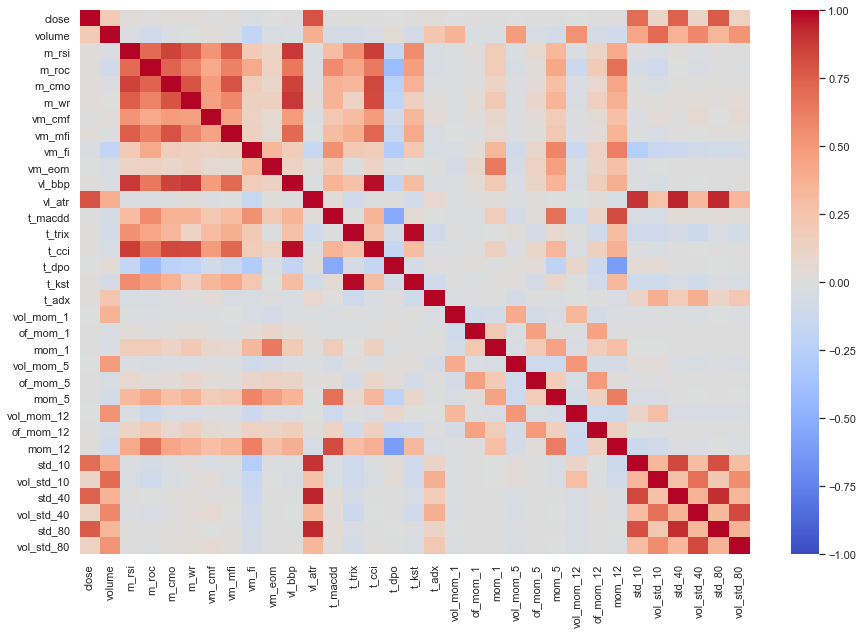

In [377]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [378]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))
hc_list

array([['close', 'std_80'],
       ['close', 'std_80'],
       ['close', 'vl_atr'],
       ['close', 'vl_atr'],
       ['m_cmo', 'm_rsi'],
       ['m_cmo', 'm_rsi'],
       ['m_cmo', 'm_wr'],
       ['m_cmo', 'm_wr'],
       ['m_cmo', 't_cci'],
       ['m_cmo', 't_cci'],
       ['m_cmo', 'vl_bbp'],
       ['m_cmo', 'vl_bbp'],
       ['m_cmo', 'vm_mfi'],
       ['m_cmo', 'vm_mfi'],
       ['m_rsi', 'm_wr'],
       ['m_rsi', 'm_wr'],
       ['m_rsi', 't_cci'],
       ['m_rsi', 't_cci'],
       ['m_rsi', 'vl_bbp'],
       ['m_rsi', 'vl_bbp'],
       ['m_rsi', 'vm_mfi'],
       ['m_rsi', 'vm_mfi'],
       ['m_wr', 't_cci'],
       ['m_wr', 't_cci'],
       ['m_wr', 'vl_bbp'],
       ['m_wr', 'vl_bbp'],
       ['mom_12', 't_macdd'],
       ['mom_12', 't_macdd'],
       ['std_10', 'std_40'],
       ['std_10', 'std_40'],
       ['std_10', 'std_80'],
       ['std_10', 'std_80'],
       ['std_10', 'vl_atr'],
       ['std_10', 'vl_atr'],
       ['std_40', 'std_80'],
       ['std_40', 'std_80'],


In [379]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['m_rsi', 'm_wr', 'std_40', 'std_80', 't_cci', 't_macdd', 't_trix',
       'vl_atr', 'vl_bbp', 'vm_mfi', 'vol_std_80'], dtype='<U10')

In [380]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

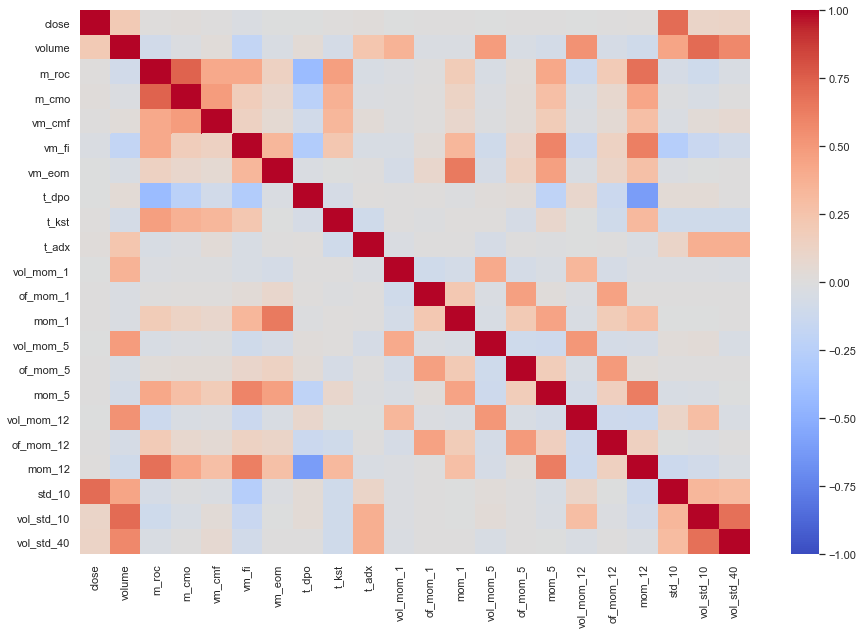

In [381]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

#### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

#### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

#### Sentiments

We can get features from Natural Language Process.

Working on this.

#### Feature Scaling

 
minmax

In [382]:
raw_X = mkt1.shift(1).dropna().copy()

scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X)
raw_X_scaled = scaler.transform(raw_X)

scaled_X = pd.DataFrame(raw_X_scaled,index=raw_X.index,columns=raw_X.columns)

#### Feature Selection
- Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

- PCA - linear

In [383]:
# PCA

n=10
pca = PCA(n)
pca.fit(scaled_X)
X_pca = pca.transform(scaled_X)

pca_X = pd.DataFrame(X_pca, index=scaled_X.index)
pca_X

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2019-01-01 03:40:00,-0.119781,-0.117135,-0.019936,-0.059105,0.031007,0.002558,-0.016647,0.054608,0.042637,-0.002308
2019-01-01 03:45:00,-0.123147,-0.060448,-0.029138,-0.058249,0.017783,0.002204,-0.002747,0.006934,0.007243,0.000891
2019-01-01 03:50:00,-0.123105,-0.060235,-0.028129,-0.059742,0.018433,0.002192,0.003256,0.004725,0.010115,0.000176
2019-01-01 03:55:00,-0.116900,-0.180512,-0.015656,-0.059838,0.014595,0.000814,-0.006029,0.022854,-0.002393,0.000470
2019-01-01 04:00:00,-0.112678,-0.285483,-0.016972,-0.059166,0.030516,0.003017,-0.004454,0.023040,0.010701,0.004514
...,...,...,...,...,...,...,...,...,...,...
2021-07-13 23:40:00,0.282931,0.080774,-0.184137,-0.029557,0.035459,-0.021764,-0.026783,0.007530,-0.018840,-0.024587
2021-07-13 23:45:00,0.288480,-0.048927,-0.183256,-0.032222,0.076176,-0.012530,-0.019081,-0.001700,0.005724,-0.012434
2021-07-13 23:50:00,0.283981,0.018756,-0.183115,-0.033585,0.083445,-0.007618,-0.005117,-0.003203,0.005225,-0.016490


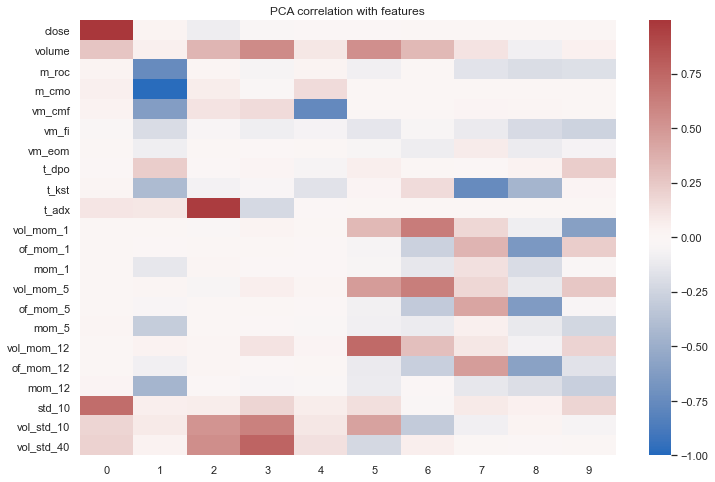

In [384]:
integrated_X = scaled_X.join(pca_X)
corr = integrated_X.corr().where(np.tril(np.ones(integrated_X.corr().shape)).astype(np.bool)).iloc[-n:,:-n].T
f = plt.figure(figsize=(12, 8))
sns.heatmap(corr,cmap='vlag',vmin=-1)
plt.title('PCA correlation with features')
plt.savefig('image/pcacorr.jpg')
plt.show();

### 4.2. Prediction Model

#### Cross-Validation/ Simple Split

To train and test, you need to take account cross-validation.



In [385]:
y = pnllabel.copy().rename('y')

In [386]:
tmp_data = pca_X.copy() # or pca_X
tmp_data = tmp_data.join(y)
tmp_data.dropna(inplace=True)

X2 = tmp_data.iloc[:,:-1]
y2 = tmp_data.iloc[:,-1]

In [387]:
train_data = tmp_data.loc[:'2021-3-1',:]
test_data = tmp_data.loc['2021-3-1':,:]

#### AutoML with autogluon and select the best model

In [388]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

In [470]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20210715_110411\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210715_110411\"
AutoGluon Version:  0.2.0
Train Data Rows:    11260
Train Data Columns: 10
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, -1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1.0, class 0 = -1.0
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1.0) vs negative (-1.0) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPip

[1000]	train_set's binary_logloss: 0.439924	train_set's precision: 0.834384	valid_set's binary_logloss: 0.650689	valid_set's precision: 0.640279
[2000]	train_set's binary_logloss: 0.326348	train_set's precision: 0.924228	valid_set's binary_logloss: 0.652438	valid_set's precision: 0.654182


	0.6591	 = Validation precision score
	19.06s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	0.6475	 = Validation precision score
	4.79s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.6419	 = Validation precision score
	1.32s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.6433	 = Validation precision score
	2.51s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	0.6455	 = Validation precision score
	6.34s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.6456	 = Validation precision score
	0.54s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.6398	 = Validation precision score
	0.63s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.6303	 = Validation precision score
	10.55s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: 

[20:04:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.6367	 = Validation precision score
	4.87s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model: LightGBMLarge ...
	0.6597	 = Validation precision score
	4.69s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.6765	 = Validation precision score
	1.5s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 59.93s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20210715_110411\")


In [471]:
result = predictor.leaderboard(test_data, silent=True)
result

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesGini,0.615087,0.645636,0.240059,0.108107,0.542423,0.240059,0.108107,0.542423,1,True,8
1,XGBoost,0.597430,0.636700,0.129653,0.011967,4.871977,0.129653,0.011967,4.871977,1,True,11
2,RandomForestEntr,0.595376,0.643326,0.175530,0.108101,2.505291,0.175530,0.108101,2.505291,1,True,6
3,ExtraTreesEntr,0.592157,0.639791,0.218997,0.107863,0.632621,0.218997,0.107863,0.632621,1,True,9
4,LightGBM,0.584388,0.647541,0.013964,0.008976,4.788202,0.013964,0.008976,4.788202,1,True,4
5,RandomForestGini,0.569853,0.641921,0.180242,0.109094,1.319477,0.180242,0.109094,1.319477,1,True,5
6,CatBoost,0.569177,0.645527,0.006982,0.005983,6.338305,0.006982,0.005983,6.338305,1,True,7
7,WeightedEnsemble_L2,0.567847,0.676508,0.894979,0.586481,29.847548,0.012966,0.002992,1.497997,2,True,13
8,NeuralNetFastAI,0.563327,0.630290,0.047872,0.024933,10.545812,0.047872,0.024933,10.545812,1,True,10
9,LightGBMLarge,0.557196,0.659722,0.028922,0.011968,4.693454,0.028922,0.011968,4.693454,1,True,12


#### Results

In [472]:
best_model = result.model[0]

In [473]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print("Predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: precision on test data: 0.6150870406189555
Evaluations on test data:
{
    "precision": 0.6150870406189555,
    "accuracy": 0.5500740009866798,
    "balanced_accuracy": 0.5543196062620998,
    "mcc": 0.12459822789959966,
    "f1": 0.4108527131782946,
    "recall": 0.3084384093113482
}


Predictions:  
 timestamp
2021-03-01 00:40:00    1.0
2021-03-01 00:45:00    1.0
2021-03-01 00:50:00    1.0
2021-03-01 01:30:00    1.0
2021-03-01 01:45:00    1.0
                      ... 
2021-07-12 10:35:00   -1.0
2021-07-12 10:50:00   -1.0
2021-07-12 11:05:00   -1.0
2021-07-12 11:10:00   -1.0
2021-07-12 16:40:00   -1.0
Name: y, Length: 2027, dtype: float64


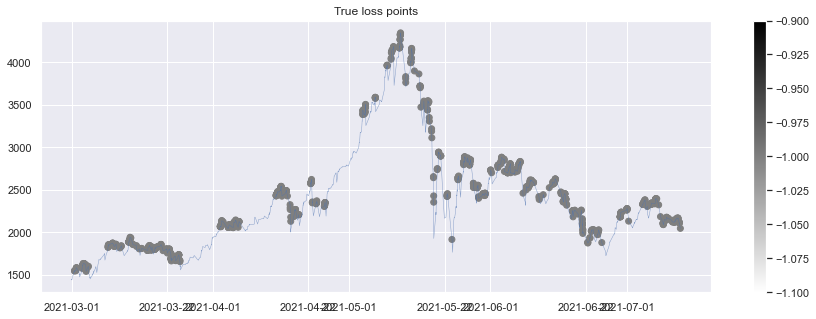

In [474]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

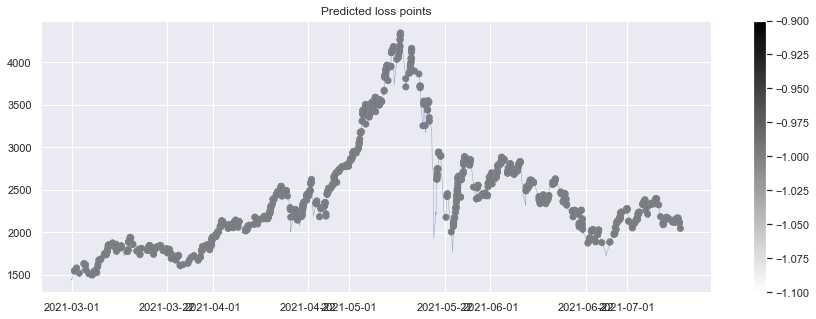

In [475]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [476]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

 1.0    318
-1.0    199
Name: y, dtype: int64

In [477]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())\

이익확률 pi:  0.6150870406189555


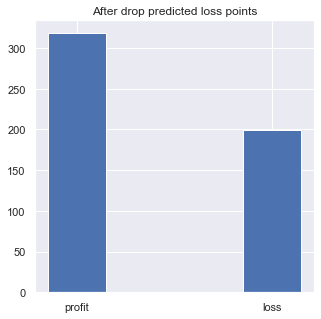

In [478]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.75

In [479]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

,-1.0,1.0
timestamp,,
2021-03-01 00:40:00,0.082709,0.917291
2021-03-01 00:45:00,0.085185,0.914815
2021-03-01 00:50:00,0.065417,0.934583
2021-03-01 01:30:00,0.101850,0.898150
2021-03-01 01:45:00,0.068446,0.931554
...,...,...
2021-07-12 10:35:00,0.714798,0.285202
2021-07-12 10:50:00,0.836138,0.163861
2021-07-12 11:05:00,0.792561,0.207439


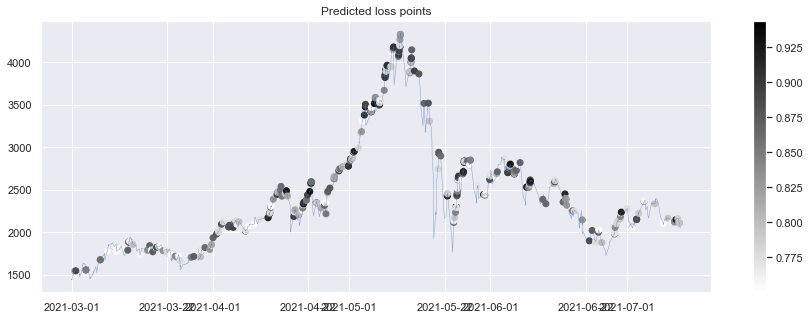

In [480]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.75]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [481]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.75].index)
predlabel2.value_counts()

 1.0    833
-1.0    740
Name: y, dtype: int64

In [482]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())\

이익확률 pi:  0.5295613477431659


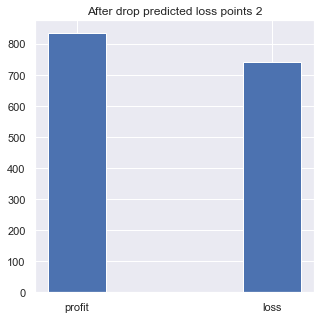

In [483]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [484]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.75].index)
finret

timestamp
2021-03-01 00:40:00    0.049547
2021-03-01 00:45:00    0.051142
2021-03-01 00:50:00    0.049589
2021-03-01 01:30:00    0.053901
2021-03-01 01:45:00    0.052823
                         ...   
2021-07-12 03:55:00   -0.056957
2021-07-12 04:10:00   -0.057960
2021-07-12 10:35:00   -0.052452
2021-07-12 11:10:00   -0.056921
2021-07-12 16:40:00   -0.052365
Name: ret, Length: 1573, dtype: float64

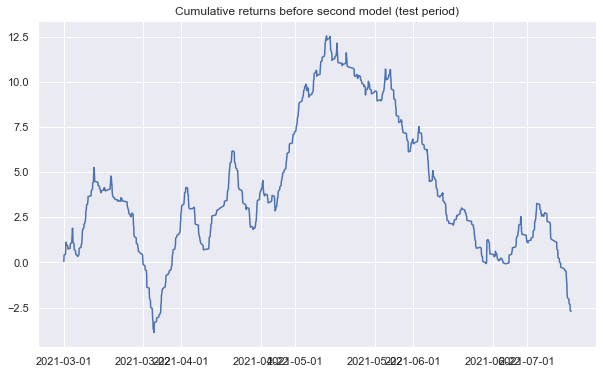

In [485]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

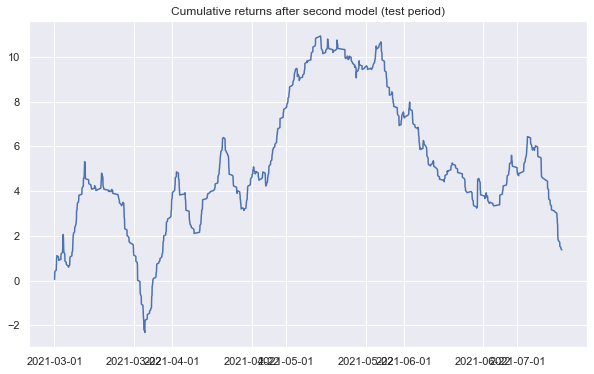

In [486]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### 4.3. Trading

#### bet sizing

- Kelly rules
- Use predicted probabilities as bet confidence

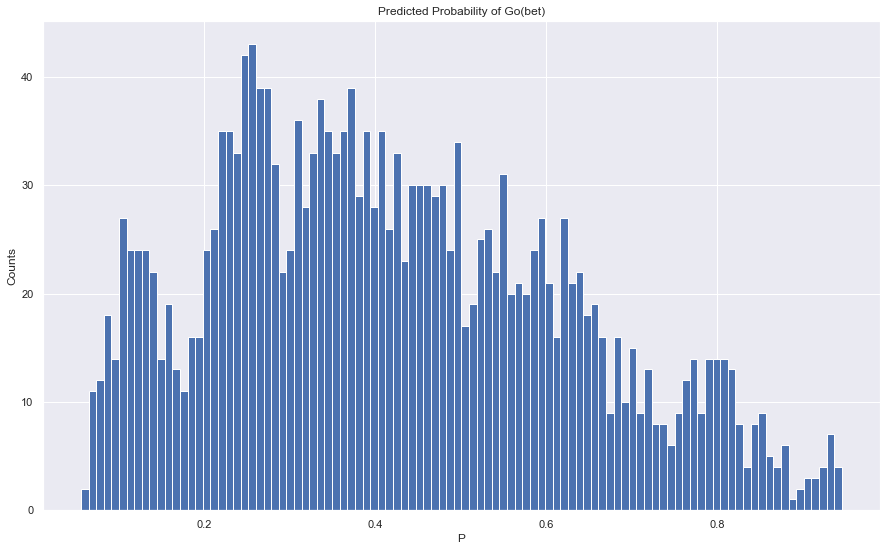

In [487]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

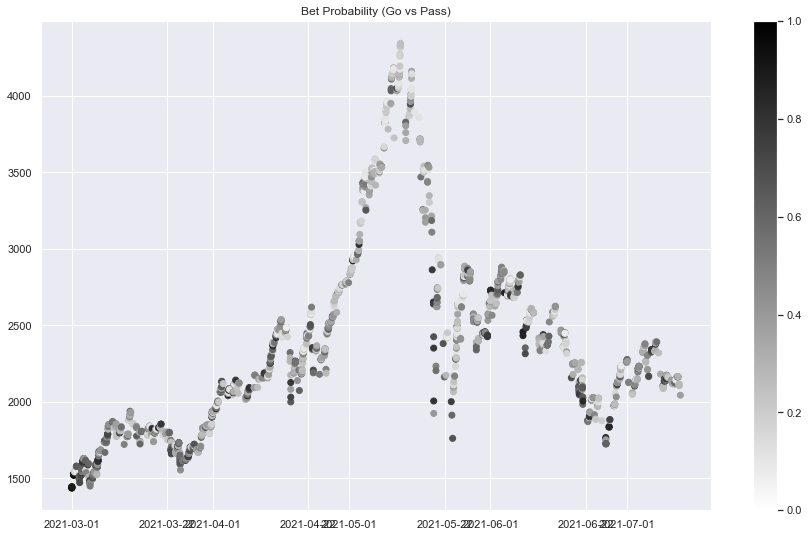

In [488]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

In [489]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [490]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [491]:
prob = p.copy()

m = get_signal(prob, 2)
m = discretize(m, 0.25)

In [492]:
m

timestamp
2021-03-01 00:40:00    0.75
2021-03-01 00:45:00    0.75
2021-03-01 00:50:00    1.00
2021-03-01 01:30:00    0.75
2021-03-01 01:45:00    1.00
                       ... 
2021-07-12 10:35:00   -0.25
2021-07-12 10:50:00   -0.75
2021-07-12 11:05:00   -0.50
2021-07-12 11:10:00   -0.50
2021-07-12 16:40:00   -0.25
Name: 1.0, Length: 2027, dtype: float64

In [493]:
m.loc[m[m<0].index] = 0
m

timestamp
2021-03-01 00:40:00    0.75
2021-03-01 00:45:00    0.75
2021-03-01 00:50:00    1.00
2021-03-01 01:30:00    0.75
2021-03-01 01:45:00    1.00
                       ... 
2021-07-12 10:35:00    0.00
2021-07-12 10:50:00    0.00
2021-07-12 11:05:00    0.00
2021-07-12 11:10:00    0.00
2021-07-12 16:40:00    0.00
Name: 1.0, Length: 2027, dtype: float64

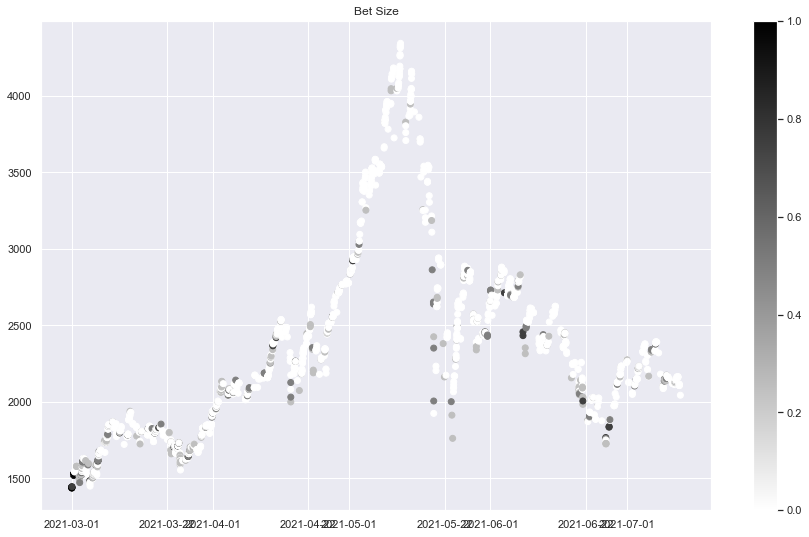

In [494]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [495]:
barrier_t = barrier.loc[y_true2.index]

In [496]:
bet_size = m*initial_money

In [497]:
wallet = tb.get_wallet(close,barrier_t,initial_money, bet_size)
wallet

,exit,price,money_spent,money_receive,buy_amount,sell_amount,n_stock,cash_inventory
timestamp,,,,,,,,
2021-03-01 00:40:00,2021-03-01 10:10:00,1443.44,1.082580e+09,0.000000e+00,750000.0,0.0,750000.0,-1.081580e+09
2021-03-01 00:45:00,2021-03-01 10:10:00,1441.14,1.080855e+09,0.000000e+00,750000.0,0.0,1500000.0,-2.162435e+09
2021-03-01 00:50:00,2021-03-01 10:10:00,1443.38,1.443380e+09,0.000000e+00,1000000.0,0.0,2500000.0,-3.605815e+09
2021-03-01 01:30:00,2021-03-01 10:10:00,1437.17,1.077878e+09,0.000000e+00,750000.0,0.0,3250000.0,-4.683692e+09
2021-03-01 01:45:00,2021-03-01 10:10:00,1438.72,1.438720e+09,0.000000e+00,1000000.0,0.0,4250000.0,-6.122412e+09
...,...,...,...,...,...,...,...,...
2021-07-12 18:10:00,0,2027.38,0.000000e+00,2.027380e+09,0.0,1000000.0,1500000.0,-4.959425e+08
2021-07-12 18:50:00,0,2024.81,0.000000e+00,1.012405e+09,0.0,500000.0,1000000.0,5.164625e+08
2021-07-12 19:25:00,0,2023.57,0.000000e+00,5.058925e+08,0.0,250000.0,750000.0,1.022355e+09


In [498]:
eth_position = wallet.money_spent-wallet.money_receive
cash_position = wallet.cash_inventory.diff()

In [499]:
positions = pd.DataFrame()
positions['ETH'] = eth_position
positions['cash'] = cash_position

In [500]:
positions

,ETH,cash
timestamp,,
2021-03-01 00:40:00,1.082580e+09,NaN
2021-03-01 00:45:00,1.080855e+09,-1.080855e+09
2021-03-01 00:50:00,1.443380e+09,-1.443380e+09
2021-03-01 01:30:00,1.077878e+09,-1.077878e+09
2021-03-01 01:45:00,1.438720e+09,-1.438720e+09
...,...,...
2021-07-12 18:10:00,-2.027380e+09,2.027380e+09
2021-07-12 18:50:00,-1.012405e+09,1.012405e+09
2021-07-12 19:25:00,-5.058925e+08,5.058925e+08


In [501]:
ret = barrier_t.ret
ret

timestamp
2021-03-01 00:40:00    0.049547
2021-03-01 00:45:00    0.051142
2021-03-01 00:50:00    0.049589
2021-03-01 01:30:00    0.053901
2021-03-01 01:45:00    0.052823
                         ...   
2021-07-12 10:35:00   -0.052452
2021-07-12 10:50:00   -0.056484
2021-07-12 11:05:00   -0.056983
2021-07-12 11:10:00   -0.056921
2021-07-12 16:40:00   -0.052365
Name: ret, Length: 2027, dtype: float64

In [502]:
#pyfolio only supports daily returns

ret_daily = ret.resample('D').sum()
positions_daily = positions.resample('D').sum()

Start date,2021-03-01
End date,2021-07-12
Total months,6
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,1235.4%
Sharpe ratio,-0.41
Calmar ratio,-1.00
Stability,NaN
Max drawdown,-100.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.47,2021-03-08,2021-03-19,NaT,NaN
1,54.95,2021-03-02,2021-03-04,2021-03-05,4
2,0.00,2021-03-01,2021-03-01,2021-03-01,1
3,0.00,2021-03-01,2021-03-01,2021-03-01,1
4,0.00,2021-03-01,2021-03-01,2021-03-01,1


Stress Events,mean,min,max
New Normal,-2.03%,-156.82%,212.12%


Top 10 long positions of all time,max
ETH,inf%


Top 10 short positions of all time,max
ETH,-inf%


Top 10 positions of all time,max
ETH,inf%


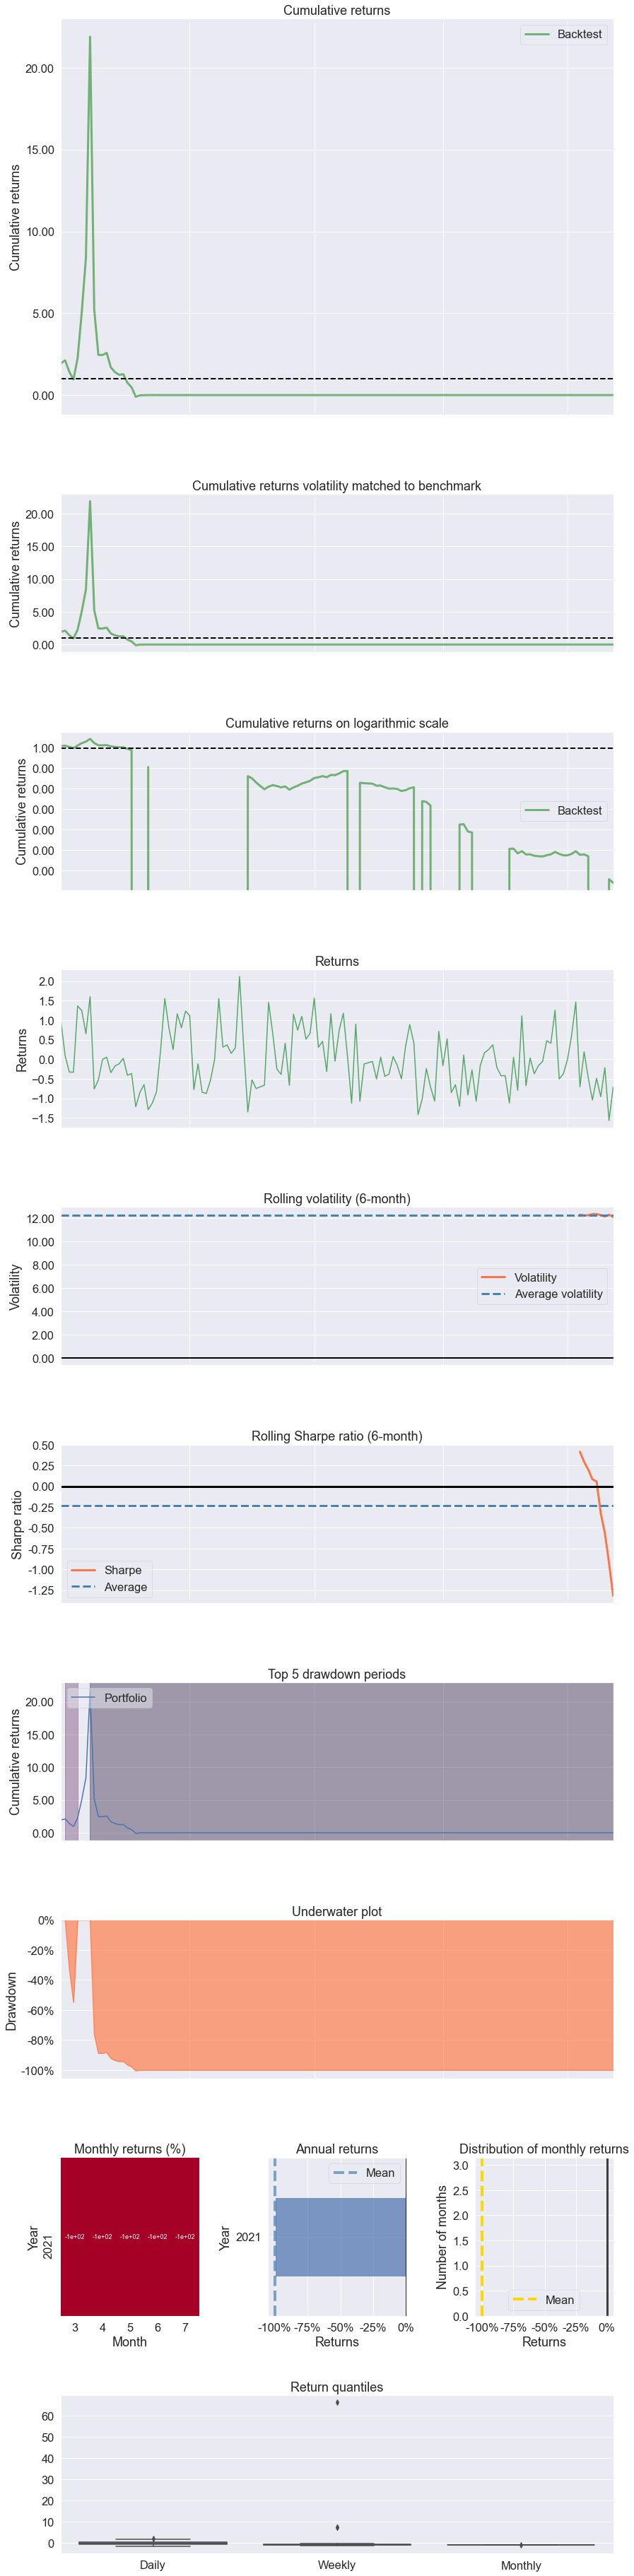

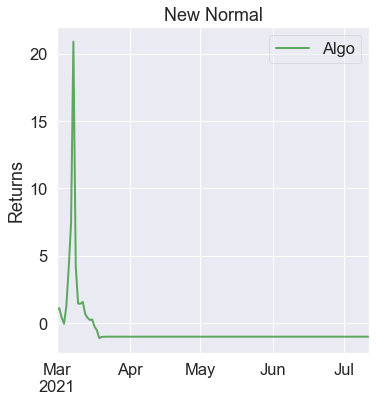

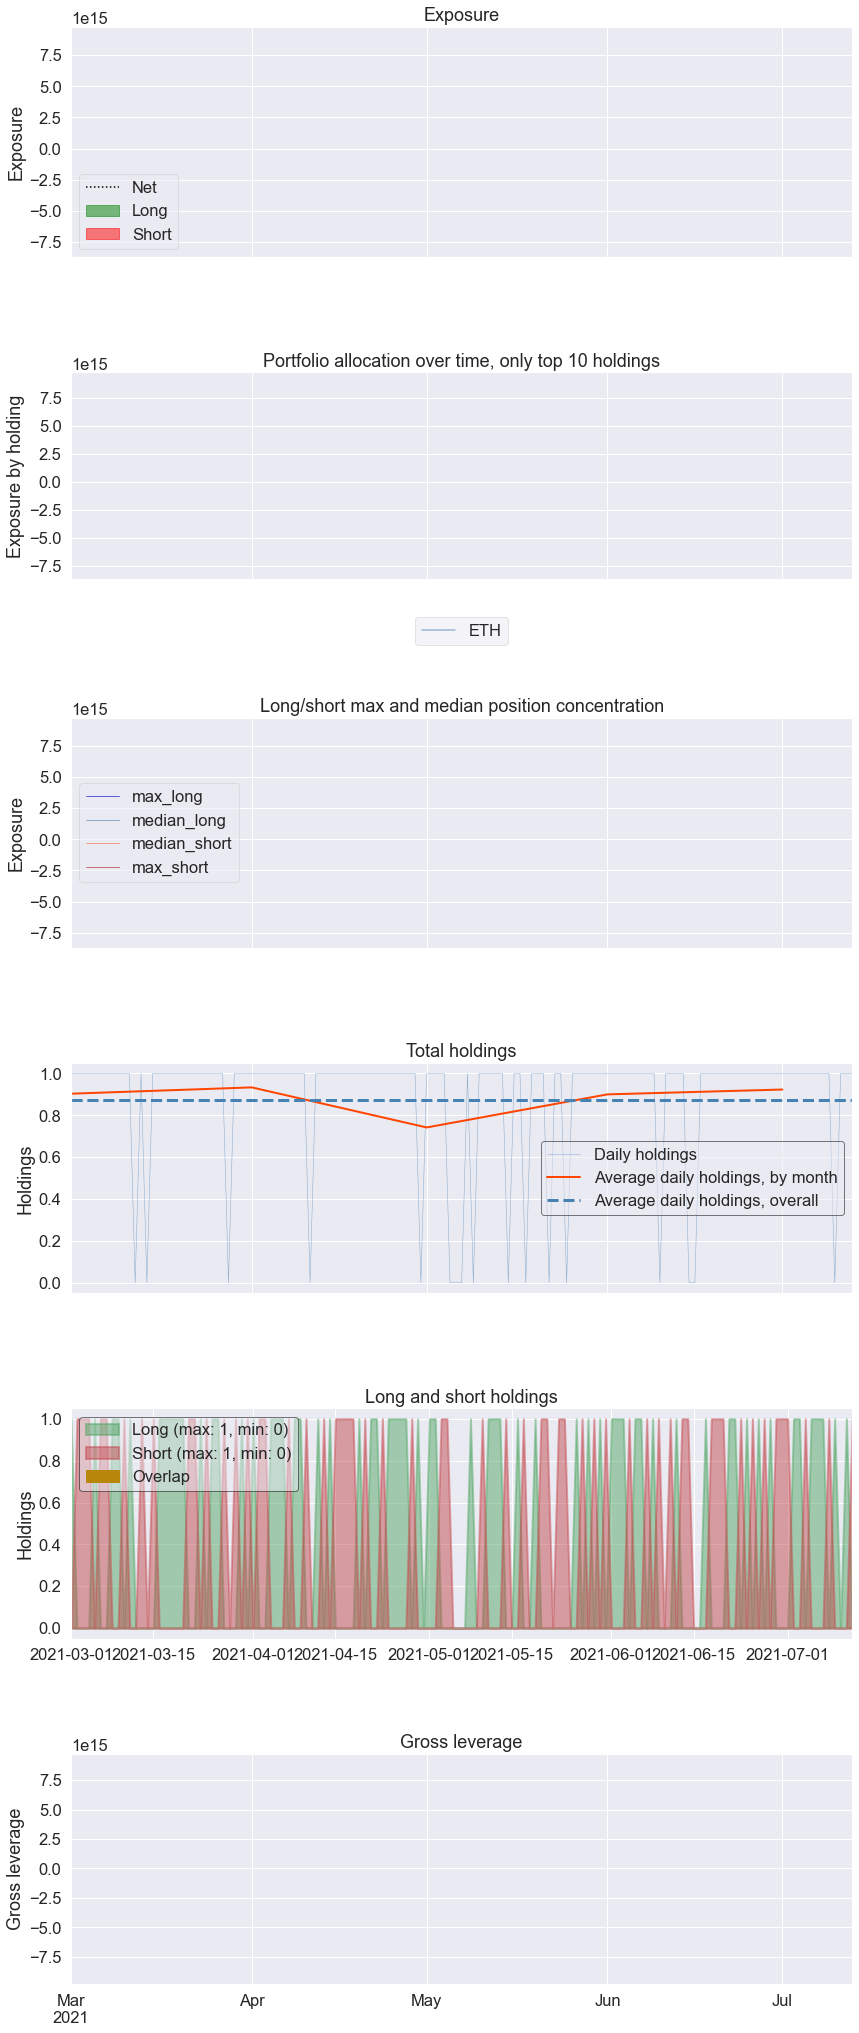

In [503]:
pf.create_full_tear_sheet(ret_daily, positions=positions_daily)